In [8]:
from keras.datasets import mnist
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import LeakyReLU, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
import time



In [9]:
# a function to format display the losses
def hmsString(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# downsample and introduce noise in the images
def downSampleAndNoisyfi(X):
    shape = X[0].shape
    X_down = []
    for x_i in X:
       x_c = cv2.resize(x_i, (shape[0]//4, shape[1]//4), interpolation = cv2.INTER_AREA)
       x_c = np.clip(x_c+ np.random.normal(0, 5, x_c.shape) , 0, 255).astype('uint8')
       X_down.append(x_c)
    X_down = np.array(X_down, dtype = 'uint8')
    return X_down



In [10]:
################# CODE FOR GENERATOR BLOCK
def Generator(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(X_input)
    X = BatchNormalization(momentum=0.5)(X)
    X = Activation('relu')(X)
    X_shortcut = X
    X = Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(X)
    X = BatchNormalization(momentum=0.5)(X)
    X = Activation('relu')(X)  
    X = Add()([X_shortcut, X])  
    X_shortcut = X
    X = Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(X)
    X = BatchNormalization(momentum=0.5)(X)
    X = Activation('relu')(X)  
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    X = UpSampling2D(size=2)(X)
    
    X = Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(X)
    X = BatchNormalization(momentum=0.5)(X)
    X = Activation('relu')(X)
    X_shortcut = X
    X = Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(X)
    X = BatchNormalization(momentum=0.5)(X)
    X = Activation('relu')(X)
    X = Add()([X_shortcut, X])
    X_shortcut = X
    X = Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(X)
    X = BatchNormalization(momentum=0.5)(X)
    X = Activation('relu')(X)   
    X = Add()([X_shortcut, X])
    X = Activation('relu')(X)
    X = UpSampling2D(size=2)(X)
    
    X_shortcut = X
    X = Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(X)
    X = BatchNormalization(momentum=0.5)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = 1, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(X)
    X = BatchNormalization(momentum=0.5)(X)
    X = Activation('relu')(X)
    
    generator_model = Model(inputs=X_input, outputs=X)
    return generator_model



In [11]:
################# CODE FOR DISCRIMINATOR BLOCK
def Discriminator(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(filters = 32, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(X_input)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = 64, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(X)
    X = BatchNormalization(momentum=0.8)(X)
    X = Activation('relu')(X)
    
    discriminator_model = Model(inputs=X_input, outputs=X)
    return discriminator_model



In [12]:
# One step of the test step
@tf.function
def train_step(X, Y, generator, discriminator, generator_optimizer, discriminator_optimizer):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(X, training=True)

    real_output = discriminator(Y, training=True)
    fake_output = discriminator(generated_images, training=False)

    gen_loss = tf.keras.losses.MSE(Y, generated_images)
    disc_loss = tf.keras.losses.MSE(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

# The main function to train the GAN
def train(X_train, Y_train, generator, discriminator, batch_size=100, epochs=50):
    generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
    discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
    start = time.time()
    for epoch in range(epochs):
        epoch_start = time.time()
        gen_loss_list = []
        disc_loss_list = []
        
        prev_i = 0
        for i in range(X_train.shape[0]):
            if((i+1)%batch_size == 0):
                t = train_step(X_train[prev_i:i+1], Y_train[prev_i:i+1], generator, discriminator, generator_optimizer, discriminator_optimizer)
                gen_loss_list.append(t[0])
                disc_loss_list.append(t[1])
                prev_i = i+1
        g_loss = np.sum(np.array(gen_loss_list)) / np.sum(np.array(gen_loss_list).shape)
        d_loss = np.sum(np.array(disc_loss_list)) / np.sum(np.array(disc_loss_list).shape)
        
        epoch_elapsed = time.time()-epoch_start
        print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hmsString(epoch_elapsed)}')
        
    elapsed = time.time()-start
    print (f'Training time: {hmsString(elapsed)}')
    


In [13]:
    
# loading the dataset(the original image are the HR 28*28 images)
(Y_train, _), (Y_test, _) = mnist.load_data()
# downsampling and introducing gaussian noise
# this downsampled and noised dataset is out X or inputs
X_train = downSampleAndNoisyfi(Y_train)
X_test = downSampleAndNoisyfi(Y_test)

# introduce a new dimension to the data (None, 28, 28, 1)
X_test = X_test[..., np.newaxis]
X_train = X_train[..., np.newaxis]
Y_train = Y_train[..., np.newaxis]
Y_test = Y_test[..., np.newaxis]

# Creating a generator and discriminator model
generator = Generator((7,7,1))
discriminator = Discriminator((28,28,1))

# Showing the summary of generator and discriminator
generator.summary()
discriminator.summary()
# training with batch size of 100 and for 50 epochs
train(X_train, Y_train, generator, discriminator, 100, 5)#50)

# save the generator model for future use
generator.save("mnist_generator_model")
generator.save("mnist_generator_model.h5")



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 7, 7, 1)]            0         []                            
                                                                                                  
 conv2d_20 (Conv2D)          (None, 7, 7, 32)             320       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 7, 7, 32)             128       ['conv2d_20[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_24 (Activation)  (None, 7, 7, 32)             0         ['batch_normalization_18

INFO:tensorflow:Assets written to: mnist_generator_model\assets


C:\Users\HP\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 9s 27ms/step


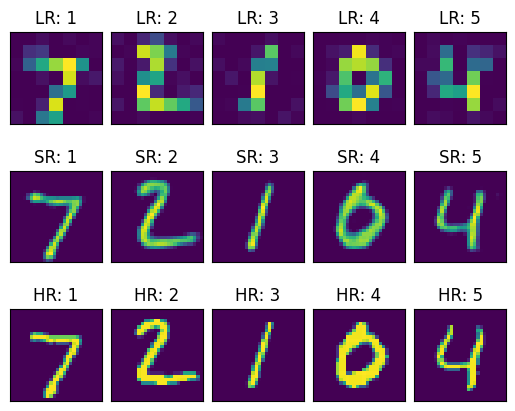

In [14]:
# testing the model
Y_pred = generator.predict(X_test)
# showing the first 5 results
fig,a =  plt.subplots(3,5)
fig.subplots_adjust(hspace=0.5, wspace=0.1)
for i in range(5):
    a[0][i].imshow(X_test[i])
    a[0][i].axes.get_xaxis().set_visible(False)
    a[0][i].axes.get_yaxis().set_visible(False)
    a[0][i].title.set_text("LR: "+str(i+1))
    
    a[1][i].imshow(Y_pred[i])
    a[1][i].axes.get_xaxis().set_visible(False)
    a[1][i].axes.get_yaxis().set_visible(False)
    a[1][i].title.set_text("SR: "+str(i+1)) 
    
    a[2][i].imshow(Y_test[i])
    a[2][i].axes.get_xaxis().set_visible(False)
    a[2][i].axes.get_yaxis().set_visible(False)
    a[2][i].title.set_text("HR: "+str(i+1)) 
    


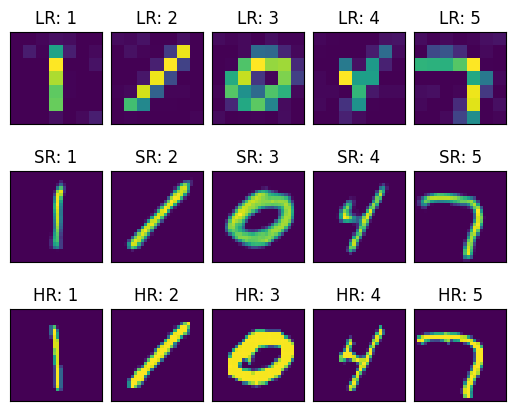

In [15]:
# showing the first 5 random results
import random
figb,ab =  plt.subplots(3,5)
figb.subplots_adjust(hspace=0.5, wspace=0.1)
for i in range(5):
    ii = random.randint(0, 10000) 
    
    ab[0][i].imshow(X_test[ii])
    ab[0][i].axes.get_xaxis().set_visible(False)
    ab[0][i].axes.get_yaxis().set_visible(False)
    ab[0][i].title.set_text("LR: "+str(i+1))
    
    ab[1][i].imshow(Y_pred[ii])
    ab[1][i].axes.get_xaxis().set_visible(False)
    ab[1][i].axes.get_yaxis().set_visible(False)
    ab[1][i].title.set_text("SR: "+str(i+1)) 
    
    ab[2][i].imshow(Y_test[ii])
    ab[2][i].axes.get_xaxis().set_visible(False)
    ab[2][i].axes.get_yaxis().set_visible(False)
    ab[2][i].title.set_text("HR: "+str(i+1)) 